# Importing base libraries

In [44]:
# Preparing and importing everything we need in this lab
from scipy.io import arff
import pandas as pd
import itertools
import sklearn.model_selection as ms
from sklearn import tree, metrics

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Preparing data

## Loading ARFF 

In [45]:
# Data
# Files are in the same folder as ipynb file
FILES = {
    'diabetes': {
        'train':'diabetes.arff',
    },
    'vote': {
        'train':'vote.arff',
    },
    'segment': {
        'train': 'segment-challenge.arff',
        'test': 'segment-test.arff',
    },
} 

DATA = {}
for (name, files) in FILES.items():
    DATA[name] = {}
    DATA[name]['train'] = {}
    DATA[name]['test'] = {}
    
    df = pd.DataFrame(arff.loadarff(files['train'])[0])
    target = df['class'].astype('str')
    all_data = df.drop(columns=['class'])
    
    if not 'test' in files:
        train_data, test_data, train_labels, test_labels = \
            ms.train_test_split(all_data, target, test_size=0.33)
    else:
        test = pd.DataFrame(arff.loadarff(files['test'])[0])
        train_data = all_data
        test_data = test.drop(columns=['class'])
        train_labels = target.astype('str')
        test_labels = test['class'].astype('str')

    DATA[name]['data'] = all_data
    DATA[name]['target'] = target
    DATA[name]['train']['data'] = train_data
    DATA[name]['test']['data'] = test_data
    DATA[name]['train']['labels'] = train_labels
    DATA[name]['test']['labels'] = test_labels
   
vote = DATA['vote']['train']['data'].astype('category')
cat_columns = vote.select_dtypes(['category']).columns
for col in cat_columns:
    vote[col] = pd.Categorical(vote[col]).codes
print(vote)
#print(dir(DATA['diabetes']['train']['labels']))

     handicapped-infants  water-project-cost-sharing  \
56                     0                           1   
110                    0                           0   
41                     1                           1   
122                    0                           0   
49                     0                           2   
238                    1                           1   
165                    0                           1   
332                    1                           0   
160                    0                           1   
46                     1                           1   
159                    0                           1   
118                    0                           1   
405                    0                           0   
92                     1                           1   
179                    1                           0   
351                    0                           0   
384                    1                        

## Helper for plot

In [46]:
def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    pyplot.imshow(matrix, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
        horizontalalignment="center",
        color="white" if matrix[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()
    pyplot.clf()
    pyplot.cla()
    pyplot.close()

## Tree printing function

In [47]:
import graphviz # needs isntalling graphviz

def print_tree(_tree):
    print("Depth: {}".format(_tree.tree_.max_depth))
    dot_data = tree.export_graphviz(_tree, out_file=None)
    graph = graphviz.Source(dot_data) 
    return graph

## Classification report function

In [48]:
def print_classification_report(labels, predictions, title='Diabetes testing train split tree'):
    "Prints the matrix and accuracy of predictions"
    accuracy = metrics.accuracy_score(labels, predictions)

    print ("Accuracy = {:.3f}".format(accuracy))

    print(metrics.classification_report(labels, predictions))

    plot_confusion_matrix(metrics.confusion_matrix(labels, predictions), 
                          classes=labels.unique(), 
                          title=title)

# Cross validation

### Demonstrating Cross Validation example using 5 folds

In [49]:
diabetes_cv_tree_model = tree.DecisionTreeClassifier(random_state=1, 
                                                     min_samples_leaf=2)

folds = 5

acc_scorer = metrics.make_scorer(metrics.accuracy_score)
recall_scorer = metrics.make_scorer(metrics.recall_score, average='weighted')
prec_scorer = metrics.make_scorer(metrics.precision_score, average='weighted')
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

scoring = {
    'accuracy': acc_scorer, 
    'recall': recall_scorer, 
    'precision' : prec_scorer,
    'f1': f1_scorer,
}

# More information:
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics
cv_tree_model_scores = ms.cross_validate(diabetes_cv_tree_model,
                                         DATA['diabetes']['data'],
                                         DATA['diabetes']['target'],
                                         scoring=scoring,
                                         cv=folds,
                                         return_train_score=True)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Evaluation results for {} folds'.format(folds))

for (k,v) in cv_tree_model_scores.items():
 print(('{}: {}').format(k,v))


Evaluation results for 5 folds
fit_time: [ 0.012  0.012  0.013  0.013  0.013]
score_time: [ 0.020  0.027  0.020  0.021  0.020]
test_accuracy: [ 0.675  0.636  0.682  0.791  0.712]
train_accuracy: [ 0.945  0.954  0.956  0.943  0.963]
test_recall: [ 0.675  0.636  0.682  0.791  0.712]
train_recall: [ 0.945  0.954  0.956  0.943  0.963]
test_precision: [ 0.660  0.646  0.680  0.788  0.706]
train_precision: [ 0.946  0.956  0.957  0.946  0.963]
test_f1: [ 0.662  0.640  0.681  0.782  0.708]
train_f1: [ 0.944  0.954  0.956  0.942  0.962]


## Cross validtion predictions

Accuracy = 0.721
                    precision    recall  f1-score   support

b'tested_negative'       0.79      0.78      0.78       500
b'tested_positive'       0.60      0.61      0.61       268

         micro avg       0.72      0.72      0.72       768
         macro avg       0.69      0.70      0.69       768
      weighted avg       0.72      0.72      0.72       768

Confusion matrix, without normalization


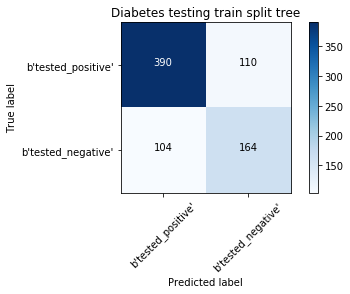

In [50]:
diabetes_cv_predict_tree_model = tree.DecisionTreeClassifier(presort=True,       # shows better results
                                                             max_features='auto',
                                                             min_samples_leaf=5, # prevent overlearning
                                                             random_state=0)

cv_tree_predictions = ms.cross_val_predict(diabetes_cv_predict_tree_model, 
                                           DATA['diabetes']['data'], 
                                           DATA['diabetes']['target'],
                                           cv=folds)

print_classification_report(DATA['diabetes']['target'],  cv_tree_predictions)

# Big CV for all algorithms
## Lab task starts here
### The Plan:
```
1. CV_report function for SOLID purpose
2. Common definition for all classifiers
3. Common dict for test and train data
4. The loop for CV all data and all algorithms
```

In [51]:
def to_numeric(data):
    data = data.astype('category')
    cat_columns = data.select_dtypes(['category']).columns
    for col in cat_columns:
        data[col] = pd.Categorical(data[col]).codes
        
    return data

# Do-it-all-at-once function for SOLID purpose
def CV_report(classifier, hyperparameters, data_params):
    # Parsing class name of a classifier
    module, class_name = classifier.rsplit('.', 1)
    __import__(module) # importing is important so module is visible in sys.modules
    classifier_class = getattr(sys.modules[module], class_name)
    
    # Parsing data
    train_data = data_params['train']['data']
    train_labels = data_params['train']['labels']
    test_data = data_params['test']['data']
    test_labels = data_params['test']['labels']
    data = data_params['data']
    target = data_params['target']

    if class_name.find("VotingClassifier") != -1:
        baseline = classifier_class(estimators=hyperparameters[0]['estimators'][0]) # Only matters for baseline
        classifier = classifier_class(estimators=hyperparameters[0]['estimators'][0])
    else:
        baseline = classifier_class() 
        classifier = classifier_class()
    
    try:
        baseline.fit(data, target) # raises exception for VotingClassifier
    except ValueError:
        data = to_numeric(data)
        baseline.fit(data, target)
        # Also convert train data
        train_data = to_numeric(train_data)
        test_data = to_numeric(test_data)
        
    base_predictions = baseline.predict(data)

    print_classification_report(target, base_predictions, title='Baseline '+classifier_class.__name__)
    
    # Creating and griding classifier
    grid = ms.GridSearchCV(
        classifier,
        hyperparameters,
        refit=True,
        scoring=f1_scorer,
        iid=True,
        cv=3 # 3 folds show better result than 5, 4 or 2 for most algorithms
    )
    
    # Fitting
    model = grid.fit(train_data, train_labels)
    print("Best parameters:")
    print(model.best_params_)
    print()
    
    # Predicting
    predictions = grid.predict(test_data)
        
    # Plotting
    print_classification_report(test_labels, predictions, title=classifier_class.__name__)

#### Data

In [52]:
# Common definitio for all classifiers
# Looks like: 'module.Classifier' : [{hyper parameters}]
import sklearn.linear_model
import sklearn.ensemble
import sklearn.naive_bayes

log_reg = sklearn.linear_model.LogisticRegression(solver='lbfgs', 
                         multi_class='multinomial',
                         random_state=1)
rand_for = sklearn.ensemble.RandomForestClassifier(n_estimators=50, random_state=1) 
gauss = sklearn.naive_bayes.GaussianNB()
CLASSIFIERS = {
    # DecisionTree
    'sklearn.tree.DecisionTreeClassifier': [{
        'presort':[True, False],       
        'max_features':['auto', 1, 2, 3],
        'min_samples_leaf':[2, 3, 4, 5, 6],
        'random_state':[0, None]
    }],
    # SVC
    'sklearn.svm.SVC': [
        {
            'kernel': ['rbf'],
            'gamma': [1e-4], # for more it counts too long
            'C': [1, 10],
        },
        {
            'kernel': ['linear'], 
            'gamma': [1e-4],
            'C': [1, 10]
        }
    ],
    # LogisticRegression
    'sklearn.linear_model.LogisticRegressionCV': [{
        'max_iter':[1000],
        'penalty':['l1'],
        'solver':['saga', 'liblinear'], # only acceptable for for l1
        'scoring':['roc_auc'],
    }, {
        'scoring':['roc_auc'],
        'penalty':['l2'],
        'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }],
    'sklearn.naive_bayes.GaussianNB': [{
        'var_smoothing': [1e-3, 1e-7, 1e-9],
    }],
    'sklearn.ensemble.RandomForestClassifier': [{
        'n_estimators':[50, 100, 120],
        'criterion':['entropy', 'gini'],
        'max_depth':[None, 8, 13],
        'min_samples_leaf':[1,3],
        'bootstrap':[True, False],
    }],
    'sklearn.ensemble.AdaBoostClassifier': [{
        'learning_rate': [1, 0.7, 0.5],
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [50, 100],
        'random_state': [None, 0, 1],
    }],
    'sklearn.ensemble.VotingClassifier': [{
        'estimators': [
            [('log_reg', log_reg), ('rand_for', rand_for)], 
            [('log_reg', log_reg), ('gauss', gauss)],
            [('rand_for', rand_for), ('gauss', gauss)],
        ],
        'voting': ['soft', 'hard'],
        'flatten_transform':[None, True],
    }],
}

# Testing and debugging

In [53]:
import warnings
warnings.simplefilter("ignore")

# Testing any classifier may come here

#classifier = 'sklearn.ensemble.AdaBoostClassifier'
#CV_report(classifier, CLASSIFIERS[classifier], DATA['diabetes'])

# Classifying and cross validating
#### Going to take a long time

USING DATASET diabetes
**********************************************************************
Using sklearn.tree.DecisionTreeClassifier...
Accuracy = 1.000
                    precision    recall  f1-score   support

b'tested_negative'       1.00      1.00      1.00       500
b'tested_positive'       1.00      1.00      1.00       268

         micro avg       1.00      1.00      1.00       768
         macro avg       1.00      1.00      1.00       768
      weighted avg       1.00      1.00      1.00       768

Confusion matrix, without normalization


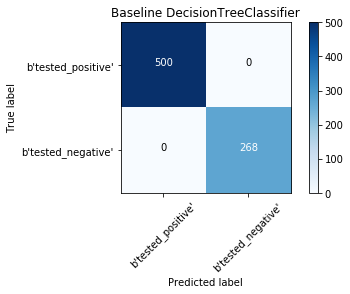

Best parameters:
{'max_features': 3, 'min_samples_leaf': 3, 'presort': True, 'random_state': 0}

Accuracy = 0.736
                    precision    recall  f1-score   support

b'tested_negative'       0.78      0.81      0.80       162
b'tested_positive'       0.65      0.60      0.62        92

         micro avg       0.74      0.74      0.74       254
         macro avg       0.71      0.71      0.71       254
      weighted avg       0.73      0.74      0.73       254

Confusion matrix, without normalization


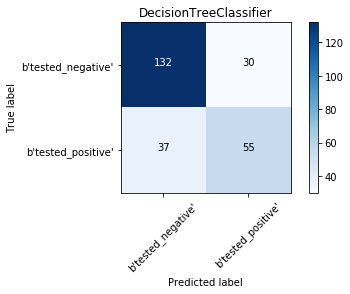

**********************************************************************
**********************************************************************
Using sklearn.svm.SVC...
Accuracy = 1.000
                    precision    recall  f1-score   support

b'tested_negative'       1.00      1.00      1.00       500
b'tested_positive'       1.00      1.00      1.00       268

         micro avg       1.00      1.00      1.00       768
         macro avg       1.00      1.00      1.00       768
      weighted avg       1.00      1.00      1.00       768

Confusion matrix, without normalization


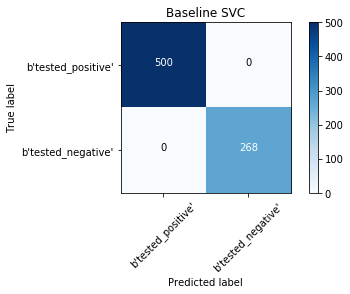

Best parameters:
{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}

Accuracy = 0.760
                    precision    recall  f1-score   support

b'tested_negative'       0.77      0.88      0.82       162
b'tested_positive'       0.72      0.54      0.62        92

         micro avg       0.76      0.76      0.76       254
         macro avg       0.75      0.71      0.72       254
      weighted avg       0.76      0.76      0.75       254

Confusion matrix, without normalization


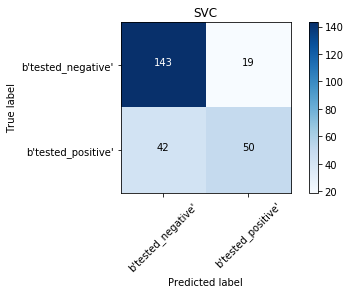

**********************************************************************
**********************************************************************
Using sklearn.linear_model.LogisticRegressionCV...
Accuracy = 0.784
                    precision    recall  f1-score   support

b'tested_negative'       0.80      0.89      0.84       500
b'tested_positive'       0.74      0.59      0.65       268

         micro avg       0.78      0.78      0.78       768
         macro avg       0.77      0.74      0.75       768
      weighted avg       0.78      0.78      0.78       768

Confusion matrix, without normalization


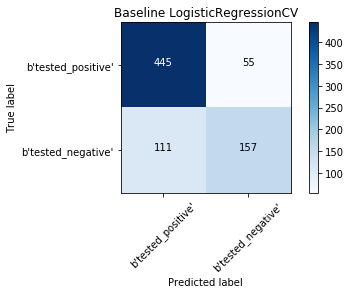

Best parameters:
{'max_iter': 1000, 'penalty': 'l1', 'scoring': 'roc_auc', 'solver': 'liblinear'}

Accuracy = 0.748
                    precision    recall  f1-score   support

b'tested_negative'       0.77      0.87      0.82       162
b'tested_positive'       0.70      0.53      0.60        92

         micro avg       0.75      0.75      0.75       254
         macro avg       0.73      0.70      0.71       254
      weighted avg       0.74      0.75      0.74       254

Confusion matrix, without normalization


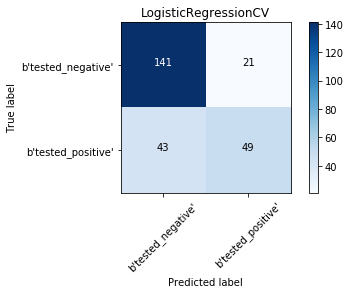

**********************************************************************
**********************************************************************
Using sklearn.naive_bayes.GaussianNB...
Accuracy = 0.763
                    precision    recall  f1-score   support

b'tested_negative'       0.80      0.84      0.82       500
b'tested_positive'       0.68      0.62      0.64       268

         micro avg       0.76      0.76      0.76       768
         macro avg       0.74      0.73      0.73       768
      weighted avg       0.76      0.76      0.76       768

Confusion matrix, without normalization


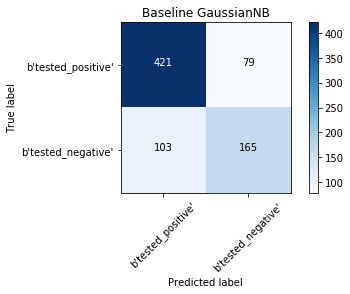

Best parameters:
{'var_smoothing': 1e-07}

Accuracy = 0.760
                    precision    recall  f1-score   support

b'tested_negative'       0.79      0.85      0.82       162
b'tested_positive'       0.69      0.61      0.65        92

         micro avg       0.76      0.76      0.76       254
         macro avg       0.74      0.73      0.73       254
      weighted avg       0.76      0.76      0.76       254

Confusion matrix, without normalization


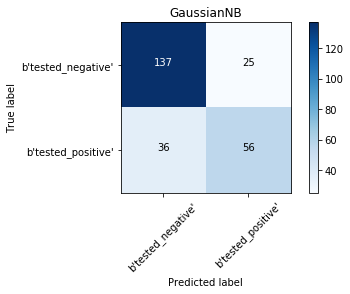

**********************************************************************
**********************************************************************
Using sklearn.ensemble.RandomForestClassifier...
Accuracy = 0.988
                    precision    recall  f1-score   support

b'tested_negative'       0.98      1.00      0.99       500
b'tested_positive'       1.00      0.97      0.98       268

         micro avg       0.99      0.99      0.99       768
         macro avg       0.99      0.98      0.99       768
      weighted avg       0.99      0.99      0.99       768

Confusion matrix, without normalization


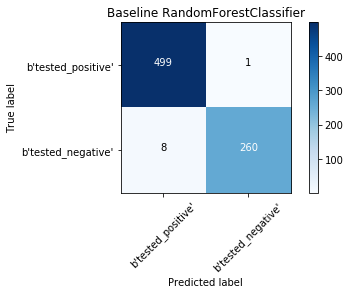

Best parameters:
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}

Accuracy = 0.748
                    precision    recall  f1-score   support

b'tested_negative'       0.78      0.84      0.81       162
b'tested_positive'       0.68      0.59      0.63        92

         micro avg       0.75      0.75      0.75       254
         macro avg       0.73      0.71      0.72       254
      weighted avg       0.74      0.75      0.74       254

Confusion matrix, without normalization


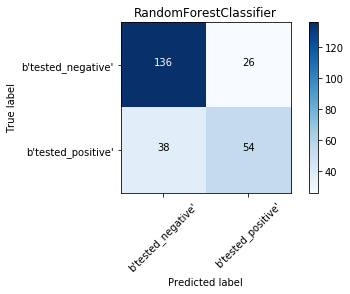

**********************************************************************
**********************************************************************
Using sklearn.ensemble.AdaBoostClassifier...
Accuracy = 0.824
                    precision    recall  f1-score   support

b'tested_negative'       0.85      0.89      0.87       500
b'tested_positive'       0.77      0.71      0.74       268

         micro avg       0.82      0.82      0.82       768
         macro avg       0.81      0.80      0.80       768
      weighted avg       0.82      0.82      0.82       768

Confusion matrix, without normalization


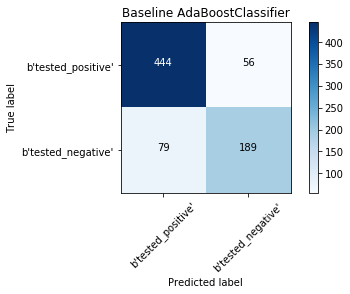

Best parameters:
{'algorithm': 'SAMME', 'learning_rate': 0.7, 'n_estimators': 50, 'random_state': None}

Accuracy = 0.744
                    precision    recall  f1-score   support

b'tested_negative'       0.78      0.84      0.81       162
b'tested_positive'       0.67      0.58      0.62        92

         micro avg       0.74      0.74      0.74       254
         macro avg       0.72      0.71      0.71       254
      weighted avg       0.74      0.74      0.74       254

Confusion matrix, without normalization


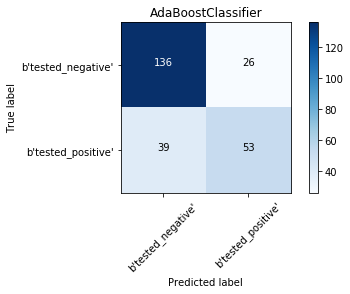

**********************************************************************
**********************************************************************
Using sklearn.ensemble.VotingClassifier...
Accuracy = 0.855
                    precision    recall  f1-score   support

b'tested_negative'       0.82      1.00      0.90       500
b'tested_positive'       1.00      0.59      0.74       268

         micro avg       0.86      0.86      0.86       768
         macro avg       0.91      0.79      0.82       768
      weighted avg       0.88      0.86      0.84       768

Confusion matrix, without normalization


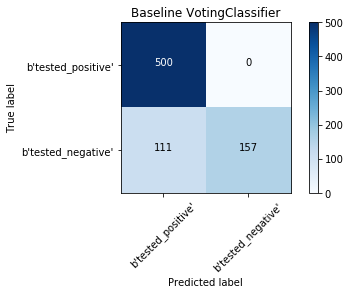

Best parameters:
{'estimators': [('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rand_for', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False))], 'flatten_transform': None, 'voting': 'soft'}

Accuracy = 0.760
                    precision    recall  f1-score   support

b'tested_negative'       0.78      0.87      0.82       162
b'tested_positive'       0.71      0.57      0.63        92

         micro

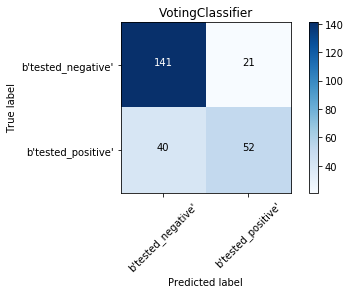

**********************************************************************
USING DATASET vote
**********************************************************************
Using sklearn.tree.DecisionTreeClassifier...
Accuracy = 1.000
                 precision    recall  f1-score   support

  b"'democrat'"       1.00      1.00      1.00       267
b"'republican'"       1.00      1.00      1.00       168

      micro avg       1.00      1.00      1.00       435
      macro avg       1.00      1.00      1.00       435
   weighted avg       1.00      1.00      1.00       435

Confusion matrix, without normalization


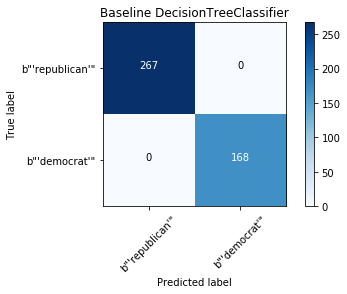

Best parameters:
{'max_features': 'auto', 'min_samples_leaf': 5, 'presort': True, 'random_state': None}

Accuracy = 0.972
                 precision    recall  f1-score   support

  b"'democrat'"       0.99      0.97      0.98        93
b"'republican'"       0.94      0.98      0.96        51

      micro avg       0.97      0.97      0.97       144
      macro avg       0.97      0.97      0.97       144
   weighted avg       0.97      0.97      0.97       144

Confusion matrix, without normalization


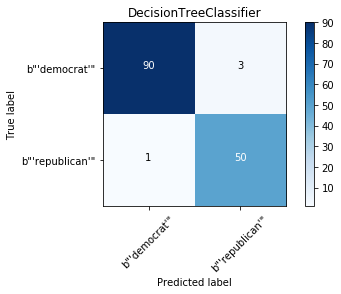

**********************************************************************
**********************************************************************
Using sklearn.svm.SVC...
Accuracy = 0.959
                 precision    recall  f1-score   support

  b"'democrat'"       0.99      0.94      0.97       267
b"'republican'"       0.92      0.98      0.95       168

      micro avg       0.96      0.96      0.96       435
      macro avg       0.95      0.96      0.96       435
   weighted avg       0.96      0.96      0.96       435

Confusion matrix, without normalization


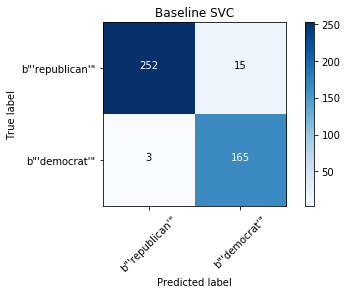

Best parameters:
{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}

Accuracy = 0.951
                 precision    recall  f1-score   support

  b"'democrat'"       0.97      0.96      0.96        93
b"'republican'"       0.92      0.94      0.93        51

      micro avg       0.95      0.95      0.95       144
      macro avg       0.95      0.95      0.95       144
   weighted avg       0.95      0.95      0.95       144

Confusion matrix, without normalization


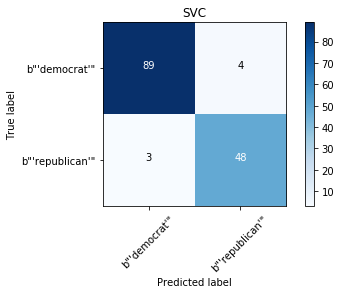

**********************************************************************
**********************************************************************
Using sklearn.linear_model.LogisticRegressionCV...
Accuracy = 0.959
                 precision    recall  f1-score   support

  b"'democrat'"       0.98      0.96      0.97       267
b"'republican'"       0.93      0.96      0.95       168

      micro avg       0.96      0.96      0.96       435
      macro avg       0.95      0.96      0.96       435
   weighted avg       0.96      0.96      0.96       435

Confusion matrix, without normalization


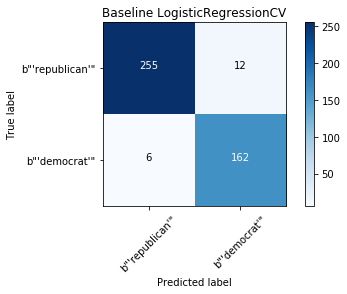

Best parameters:
{'penalty': 'l2', 'scoring': 'roc_auc', 'solver': 'liblinear'}

Accuracy = 0.951
                 precision    recall  f1-score   support

  b"'democrat'"       0.97      0.96      0.96        93
b"'republican'"       0.92      0.94      0.93        51

      micro avg       0.95      0.95      0.95       144
      macro avg       0.95      0.95      0.95       144
   weighted avg       0.95      0.95      0.95       144

Confusion matrix, without normalization


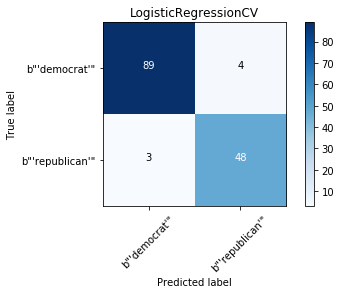

**********************************************************************
**********************************************************************
Using sklearn.naive_bayes.GaussianNB...
Accuracy = 0.943
                 precision    recall  f1-score   support

  b"'democrat'"       0.95      0.96      0.95       267
b"'republican'"       0.93      0.92      0.93       168

      micro avg       0.94      0.94      0.94       435
      macro avg       0.94      0.94      0.94       435
   weighted avg       0.94      0.94      0.94       435

Confusion matrix, without normalization


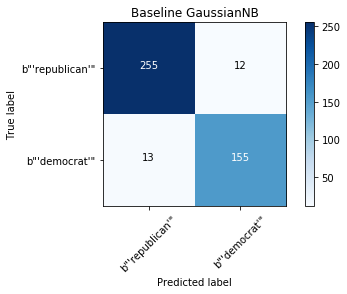

Best parameters:
{'var_smoothing': 0.001}

Accuracy = 0.965
                 precision    recall  f1-score   support

  b"'democrat'"       0.99      0.96      0.97        93
b"'republican'"       0.93      0.98      0.95        51

      micro avg       0.97      0.97      0.97       144
      macro avg       0.96      0.97      0.96       144
   weighted avg       0.97      0.97      0.97       144

Confusion matrix, without normalization


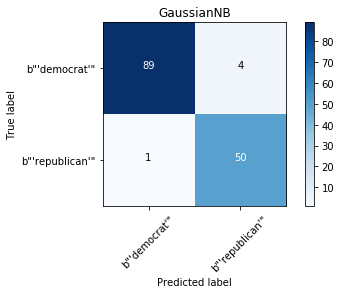

**********************************************************************
**********************************************************************
Using sklearn.ensemble.RandomForestClassifier...
Accuracy = 0.995
                 precision    recall  f1-score   support

  b"'democrat'"       1.00      1.00      1.00       267
b"'republican'"       0.99      0.99      0.99       168

      micro avg       1.00      1.00      1.00       435
      macro avg       1.00      1.00      1.00       435
   weighted avg       1.00      1.00      1.00       435

Confusion matrix, without normalization


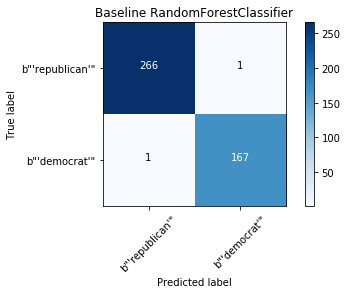

Best parameters:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 120}

Accuracy = 0.986
                 precision    recall  f1-score   support

  b"'democrat'"       1.00      0.98      0.99        93
b"'republican'"       0.96      1.00      0.98        51

      micro avg       0.99      0.99      0.99       144
      macro avg       0.98      0.99      0.98       144
   weighted avg       0.99      0.99      0.99       144

Confusion matrix, without normalization


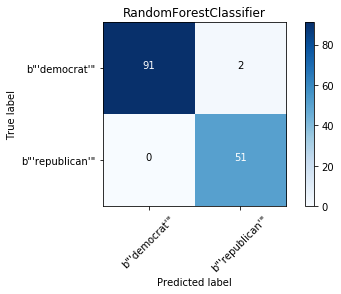

**********************************************************************
**********************************************************************
Using sklearn.ensemble.AdaBoostClassifier...
Accuracy = 0.977
                 precision    recall  f1-score   support

  b"'democrat'"       0.98      0.98      0.98       267
b"'republican'"       0.96      0.98      0.97       168

      micro avg       0.98      0.98      0.98       435
      macro avg       0.97      0.98      0.98       435
   weighted avg       0.98      0.98      0.98       435

Confusion matrix, without normalization


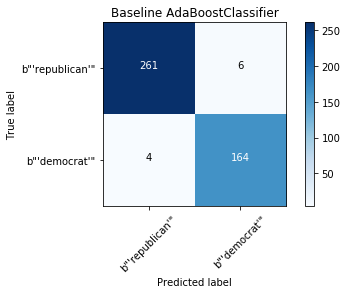

Best parameters:
{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 50, 'random_state': None}

Accuracy = 0.979
                 precision    recall  f1-score   support

  b"'democrat'"       0.98      0.99      0.98        93
b"'republican'"       0.98      0.96      0.97        51

      micro avg       0.98      0.98      0.98       144
      macro avg       0.98      0.98      0.98       144
   weighted avg       0.98      0.98      0.98       144

Confusion matrix, without normalization


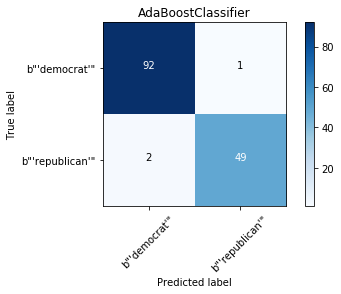

**********************************************************************
**********************************************************************
Using sklearn.ensemble.VotingClassifier...
Accuracy = 0.986
                 precision    recall  f1-score   support

  b"'democrat'"       0.98      1.00      0.99       267
b"'republican'"       1.00      0.96      0.98       168

      micro avg       0.99      0.99      0.99       435
      macro avg       0.99      0.98      0.99       435
   weighted avg       0.99      0.99      0.99       435

Confusion matrix, without normalization


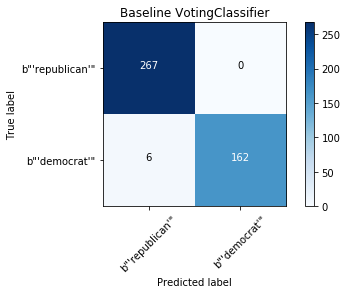

Best parameters:
{'estimators': [('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rand_for', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False))], 'flatten_transform': None, 'voting': 'soft'}

Accuracy = 0.972
                 precision    recall  f1-score   support

  b"'democrat'"       0.98      0.98      0.98        93
b"'republican'"       0.96      0.96      0.96        51

      micro avg       0

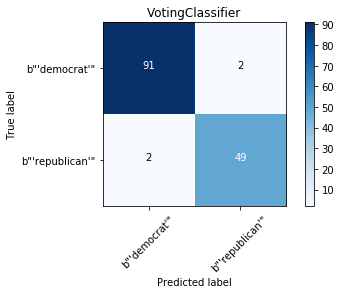

**********************************************************************
USING DATASET segment
**********************************************************************
Using sklearn.tree.DecisionTreeClassifier...
Accuracy = 1.000
              precision    recall  f1-score   support

b'brickface'       1.00      1.00      1.00       205
   b'cement'       1.00      1.00      1.00       220
  b'foliage'       1.00      1.00      1.00       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       1.00      1.00      1.00       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       1.00      1.00      1.00       204

   micro avg       1.00      1.00      1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Confusion matrix, without normalization


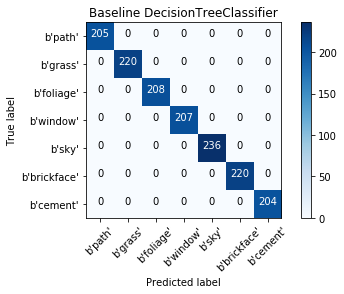

Best parameters:
{'max_features': 'auto', 'min_samples_leaf': 4, 'presort': True, 'random_state': None}

Accuracy = 0.949
              precision    recall  f1-score   support

b'brickface'       0.93      0.99      0.96       125
   b'cement'       0.92      0.94      0.93       110
  b'foliage'       0.90      0.93      0.91       122
    b'grass'       0.99      0.98      0.98       123
     b'path'       0.98      1.00      0.99        94
      b'sky'       1.00      1.00      1.00       110
   b'window'       0.95      0.83      0.89       126

   micro avg       0.95      0.95      0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.95       810

Confusion matrix, without normalization


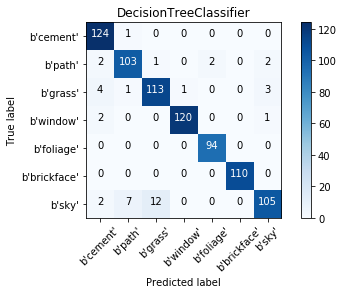

**********************************************************************
**********************************************************************
Using sklearn.svm.SVC...
Accuracy = 1.000
              precision    recall  f1-score   support

b'brickface'       1.00      1.00      1.00       205
   b'cement'       1.00      1.00      1.00       220
  b'foliage'       1.00      1.00      1.00       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       1.00      1.00      1.00       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       1.00      1.00      1.00       204

   micro avg       1.00      1.00      1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Confusion matrix, without normalization


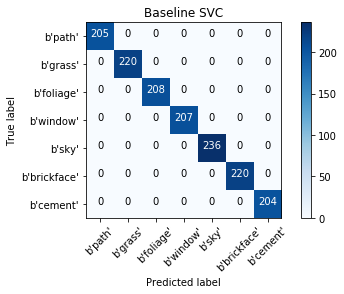

Best parameters:
{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}

Accuracy = 0.946
              precision    recall  f1-score   support

b'brickface'       0.97      0.99      0.98       125
   b'cement'       0.88      0.94      0.91       110
  b'foliage'       0.89      0.93      0.91       122
    b'grass'       1.00      0.99      1.00       123
     b'path'       1.00      1.00      1.00        94
      b'sky'       1.00      1.00      1.00       110
   b'window'       0.89      0.79      0.84       126

   micro avg       0.95      0.95      0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.94       810

Confusion matrix, without normalization


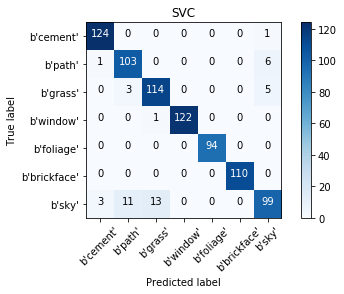

**********************************************************************
**********************************************************************
Using sklearn.linear_model.LogisticRegressionCV...
Accuracy = 0.932
              precision    recall  f1-score   support

b'brickface'       0.99      0.99      0.99       205
   b'cement'       0.90      0.86      0.88       220
  b'foliage'       0.87      0.88      0.88       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       1.00      1.00      1.00       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       0.76      0.78      0.77       204

   micro avg       0.93      0.93      0.93      1500
   macro avg       0.93      0.93      0.93      1500
weighted avg       0.93      0.93      0.93      1500

Confusion matrix, without normalization


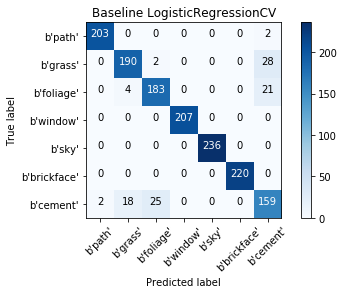

Best parameters:
{'penalty': 'l2', 'scoring': 'roc_auc', 'solver': 'lbfgs'}

Accuracy = 0.915
              precision    recall  f1-score   support

b'brickface'       0.97      0.98      0.98       125
   b'cement'       0.84      0.87      0.86       110
  b'foliage'       0.86      0.87      0.87       122
    b'grass'       0.99      0.97      0.98       123
     b'path'       0.96      1.00      0.98        94
      b'sky'       1.00      1.00      1.00       110
   b'window'       0.79      0.74      0.76       126

   micro avg       0.91      0.91      0.91       810
   macro avg       0.92      0.92      0.92       810
weighted avg       0.91      0.91      0.91       810

Confusion matrix, without normalization


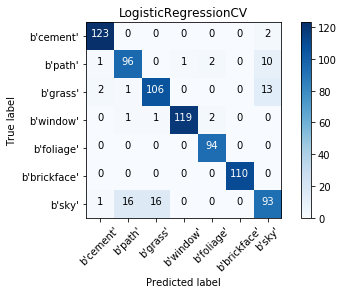

**********************************************************************
**********************************************************************
Using sklearn.naive_bayes.GaussianNB...
Accuracy = 0.814
              precision    recall  f1-score   support

b'brickface'       0.75      0.96      0.84       205
   b'cement'       0.86      0.86      0.86       220
  b'foliage'       0.73      0.21      0.32       208
    b'grass'       1.00      0.99      1.00       207
     b'path'       0.98      0.95      0.97       236
      b'sky'       1.00      0.99      1.00       220
   b'window'       0.48      0.71      0.57       204

   micro avg       0.81      0.81      0.81      1500
   macro avg       0.83      0.81      0.79      1500
weighted avg       0.83      0.81      0.80      1500

Confusion matrix, without normalization


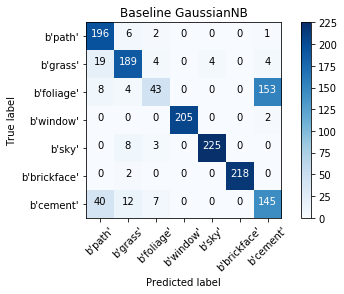

Best parameters:
{'var_smoothing': 1e-07}

Accuracy = 0.772
              precision    recall  f1-score   support

b'brickface'       0.74      0.96      0.83       125
   b'cement'       0.82      0.88      0.85       110
  b'foliage'       0.62      0.13      0.22       122
    b'grass'       1.00      0.97      0.98       123
     b'path'       0.98      0.95      0.96        94
      b'sky'       1.00      0.99      1.00       110
   b'window'       0.41      0.60      0.49       126

   micro avg       0.77      0.77      0.77       810
   macro avg       0.79      0.78      0.76       810
weighted avg       0.78      0.77      0.75       810

Confusion matrix, without normalization


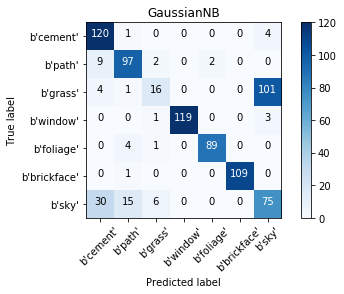

**********************************************************************
**********************************************************************
Using sklearn.ensemble.RandomForestClassifier...
Accuracy = 0.999
              precision    recall  f1-score   support

b'brickface'       1.00      1.00      1.00       205
   b'cement'       1.00      1.00      1.00       220
  b'foliage'       1.00      1.00      1.00       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       1.00      1.00      1.00       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       1.00      1.00      1.00       204

   micro avg       1.00      1.00      1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Confusion matrix, without normalization


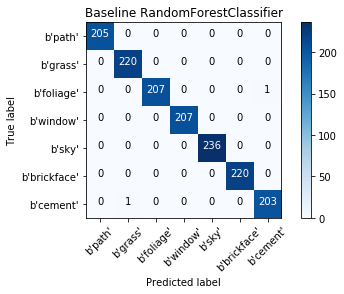

Best parameters:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'n_estimators': 120}

Accuracy = 0.973
              precision    recall  f1-score   support

b'brickface'       0.95      0.99      0.97       125
   b'cement'       0.96      0.97      0.96       110
  b'foliage'       0.94      0.96      0.95       122
    b'grass'       1.00      0.98      0.99       123
     b'path'       1.00      1.00      1.00        94
      b'sky'       1.00      1.00      1.00       110
   b'window'       0.97      0.92      0.94       126

   micro avg       0.97      0.97      0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810

Confusion matrix, without normalization


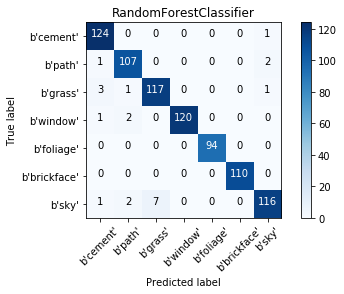

**********************************************************************
**********************************************************************
Using sklearn.ensemble.AdaBoostClassifier...
Accuracy = 0.442
              precision    recall  f1-score   support

b'brickface'       0.00      0.00      0.00       205
   b'cement'       0.00      0.00      0.00       220
  b'foliage'       0.00      0.00      0.00       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       0.22      1.00      0.36       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       0.00      0.00      0.00       204

   micro avg       0.44      0.44      0.44      1500
   macro avg       0.32      0.43      0.34      1500
weighted avg       0.32      0.44      0.34      1500

Confusion matrix, without normalization


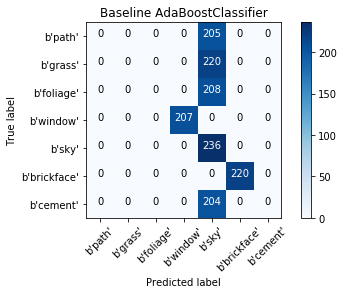

Best parameters:
{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100, 'random_state': None}

Accuracy = 0.800
              precision    recall  f1-score   support

b'brickface'       0.95      0.98      0.97       125
   b'cement'       0.53      0.93      0.67       110
  b'foliage'       0.69      0.87      0.77       122
    b'grass'       1.00      0.98      0.99       123
     b'path'       0.91      0.32      0.47        94
      b'sky'       1.00      1.00      1.00       110
   b'window'       0.79      0.45      0.58       126

   micro avg       0.80      0.80      0.80       810
   macro avg       0.84      0.79      0.78       810
weighted avg       0.84      0.80      0.79       810

Confusion matrix, without normalization


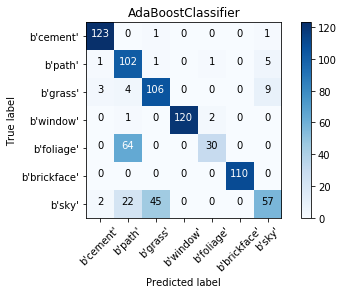

**********************************************************************
**********************************************************************
Using sklearn.ensemble.VotingClassifier...
Accuracy = 0.971
              precision    recall  f1-score   support

b'brickface'       1.00      1.00      1.00       205
   b'cement'       0.92      1.00      0.96       220
  b'foliage'       0.90      0.99      0.94       208
    b'grass'       1.00      1.00      1.00       207
     b'path'       1.00      1.00      1.00       236
      b'sky'       1.00      1.00      1.00       220
   b'window'       1.00      0.80      0.89       204

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

Confusion matrix, without normalization


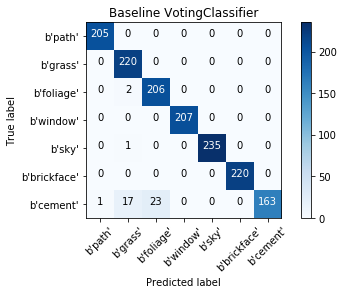

Best parameters:
{'estimators': [('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rand_for', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False))], 'flatten_transform': None, 'voting': 'soft'}

Accuracy = 0.952
              precision    recall  f1-score   support

b'brickface'       0.98      0.99      0.99       125
   b'cement'       0.92      0.93      0.92       110
  b'foliage'       0.90      0.96

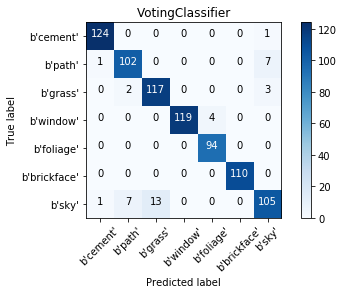

**********************************************************************


In [54]:
for (dataset_name, data) in DATA.items():
    print('USING DATASET {}'.format(dataset_name))
    for (classifier, hyperparams) in CLASSIFIERS.items():
        print('*' * 70)
        print("Using {}...".format(classifier))
        # Each classificator gets initialized and passed to CV Grid
        # Then a common report is created and matrix is vizualized   
        # 'Best parameters' will show the parameters that were better than others for F-scorer
        CV_report(classifier, 
                  hyperparams, 
                  data)
        print('*' * 70)